In [43]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


In [44]:
# Step 2: Load datasets
train = pd.read_csv('walmart_train.csv')
features = pd.read_csv('walmart_features.csv')
stores = pd.read_csv('walmart_stores.csv')
test = pd.read_csv('walmart_test.csv')


In [41]:
# Step 3: Explore datasets
print("Train Dataset:")
print(train.head())
print("\nFeatures Dataset:")
print(features.head())
print("\nStores Dataset:")
print(stores.head())
print("\nTest Dataset:")
print(test.head())


Train Dataset:
   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...  MarkDown5         CPI  Unemployment  \
0        0.0        0.0        0.0  ...        0.0  211.096358         8.106   
1        0.0        0.0        0.0  ...        0.0  211.242170         8.106   
2        0.0        0.0        0.0  ...        0.0  211.289143         8.106   
3        0.0        0.0        0.0  ...        0.0  211.319643         8.106   
4        0.0        0.0        0.0  ...        0.0  211.350143         8.106   

   IsHoliday_y   

In [45]:
# Step 4: Merge datasets
train = train.merge(features, on=['Store', 'Date'], how='left')
train = train.merge(stores, on='Store', how='left')

test = test.merge(features, on=['Store', 'Date'], how='left')
test = test.merge(stores, on='Store', how='left')


In [46]:
# Step 5: Convert 'Date' to datetime and extract date features
for df in [train, test]:
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week.astype(int)


In [47]:
# ✅ Fixing 'IsHoliday' column
# Rename and convert IsHoliday column
train['IsHoliday'] = train['IsHoliday_x'].astype(int)
test['IsHoliday'] = test['IsHoliday_x'].astype(int)

# Now drop the duplicates
train.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)
test.drop(['IsHoliday_x', 'IsHoliday_y'], axis=1, inplace=True)


In [48]:
# Step 6: Handle missing values
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)


In [49]:
# Step 7: Encode categorical variables (store type)
train = pd.get_dummies(train, columns=['Type'], drop_first=True)
test = pd.get_dummies(test, columns=['Type'], drop_first=True)


In [50]:
# Step 8: Now this will work ✅
features_cols = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                 'Size', 'IsHoliday', 'Year', 'Month', 'Week', 'Type_B', 'Type_C']

X = train[features_cols]
y = train['Weekly_Sales']


In [51]:
print(train.columns)


Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price',
       'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI',
       'Unemployment', 'Size', 'Year', 'Month', 'Week', 'IsHoliday', 'Type_B',
       'Type_C'],
      dtype='object')


In [52]:
# Step 9: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
# Step 10: Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [54]:
# Step 11: Evaluate the model
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 3646.12


In [55]:
# Step 12: Prepare test data and make predictions
X_test = test[features_cols]
test['Weekly_Sales'] = model.predict(X_test)


In [56]:
# Step 13: Save predictions to CSV
submission = test[['Store', 'Dept', 'Date', 'Weekly_Sales']]
submission.to_csv('walmart_sales_predictions.csv', index=False)
print("Predictions saved to 'walmart_sales_predictions.csv'")


Predictions saved to 'walmart_sales_predictions.csv'


               Store           Dept   Weekly_Sales    Temperature  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean       22.200546      44.260317   15981.258123      60.090059   
std        12.785297      30.492054   22711.183519      18.447931   
min         1.000000       1.000000   -4988.940000      -2.060000   
25%        11.000000      18.000000    2079.650000      46.680000   
50%        22.000000      37.000000    7612.030000      62.090000   
75%        33.000000      74.000000   20205.852500      74.280000   
max        45.000000      99.000000  693099.360000     100.140000   

          Fuel_Price      MarkDown1      MarkDown2      MarkDown3  \
count  421570.000000  421570.000000  421570.000000  421570.000000   
mean        3.361027    2590.074819     879.974298     468.087665   
std         0.458515    6052.385934    5084.538801    5528.873453   
min         2.472000       0.000000    -265.760000     -29.100000   
25%         2.933000       0.0000

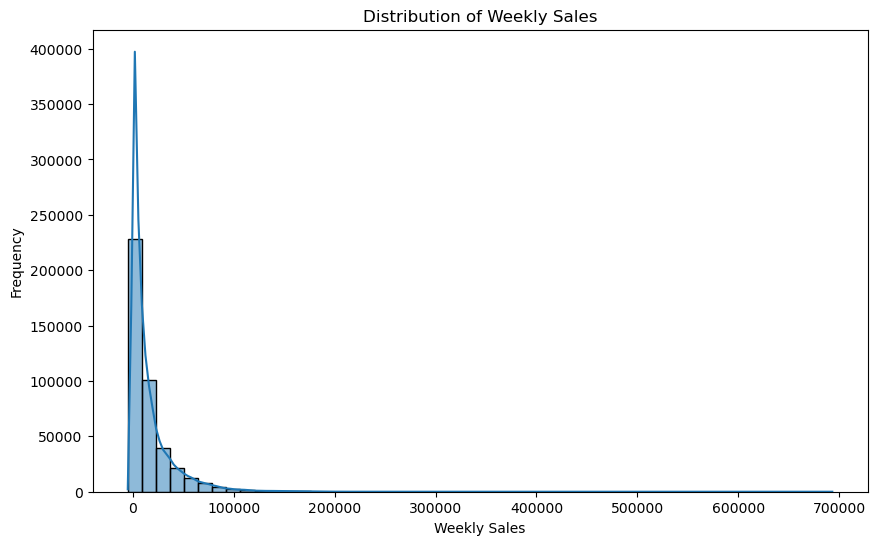

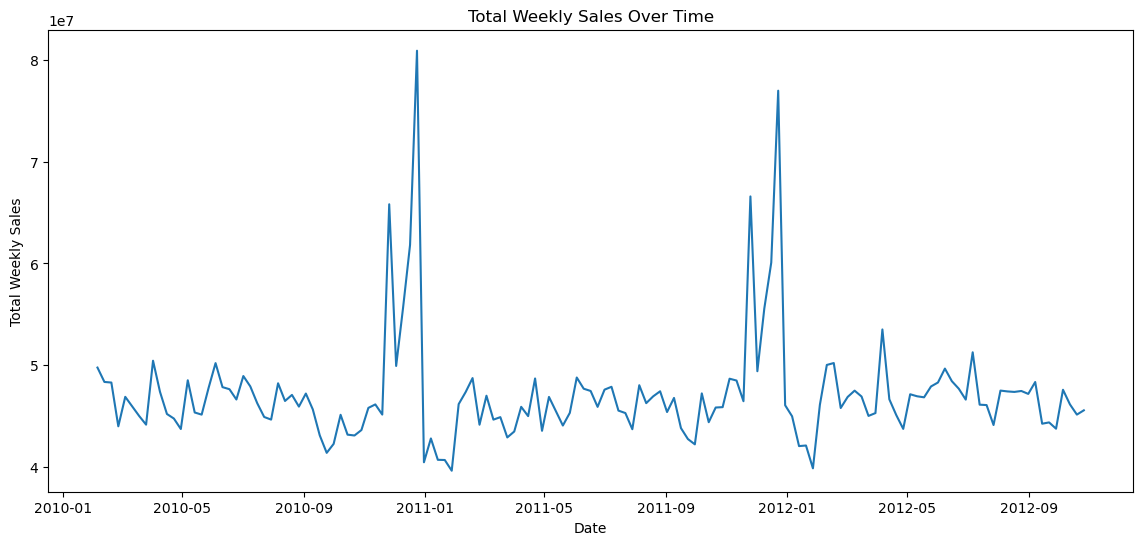

In [57]:
# Summary statistics
print(train.describe())

# Check for missing values
print(train.isnull().sum())

# Visualize sales distribution
plt.figure(figsize=(10,6))
sns.histplot(train['Weekly_Sales'], bins=50, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.show()

# Sales over time
sales_over_time = train.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(14,6))
sns.lineplot(data=sales_over_time, x='Date', y='Weekly_Sales')
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.show()
